In [1]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import tqdm as tq
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
import winsound
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
Freq = 1000 # Set Frequency To 2500 Hertz
Dur = 1000 # Set Duration To 1000 ms == 1 second

In [2]:
eta=1
R=t.pi
weight=1
BW=10

In [25]:
def V(x):
    return np.exp(-((x-R/2)**2)/(2*0.01))

#(1/2)*((x-R/2)**20)
#

ReLu=t.nn.ReLU()

def act(x):
    return np.exp(-x**2)
#t.tanh(x)
#t.sin(x) 
#np.sin(x) 
#t.sin(x)
#t.log(1+t.exp(x))

def dact(x):
    return -2*x*np.exp(-x**2)
#1/(t.cosh(x)**2)
#t.cos(x)
#np.cos(x)
#t.cos(x)
#t.exp(x)/(1+t.exp(x))

def ddact(x):
    return -2*np.exp(-x**2)+4*(x**2)*np.exp(-x**2)
#-2*(t.sinh(x))/(t.cosh(x)**3)
#-t.sin(x)
#-np.sin(x)
#-t.sin(x)
#t.exp(x)/((1+t.exp(x))**2)

def dddact(x):
    return 4*x*np.exp(-x**2)+8*x*np.exp(-x**2)-8*(x**3)*np.exp(-x**2)
#-2*(t.cosh(x)**2-3*t.sinh(x)**2)/(t.cosh(x)**4)
#-t.cos(x)
#-np.cos(x)
#-t.cos(x)
#(t.exp(x)*(1-t.exp(x)))/(1+t.exp(x))**4

def t_to_p(theta):
    m3=len(theta)
    m=np.array(m3/3, dtype=int)
    c=theta[:m]
    w=theta[m:2*m]
    b=theta[2*m:3*m]
    return c,w,b

def p_to_t(c,w,b):
    return np.concatenate((c,w,b))

def net(c,w,b,x):
    return np.matmul(c,act(w*x+b))

def dnet(c,w,b,x):
    return np.matmul(c*w,dact(w*x+b))

def ddnet(c,w,b,x):
    return np.matmul(c*w*w,ddact(w*x+b))

In [42]:
N=100

x=np.array([R*(i/N)  for i in range(N)])

def PINN_Error(theta):
    c,w,b=t_to_p(theta)
    a=0
    e_val=eigenvalue(c,w,b,x)
    for i in range(N):
        s=-ddnet(c,w,b,x[i])+V(x[i])*net(c,w,b,x[i])+eta*(net(c,w,b,x[i])**3)-e_val*net(c,w,b,x[i])
        a=a+(s)**2
    return (R/N)*a

        
def energy(theta):
    c,w,b=t_to_p(theta)
    e=0
    for i in range(N):
        e=e+(dnet(c,w,b,x[i])**2)+V(x[i])*(net(c,w,b,x[i])**2)+(eta/2)*(net(c,w,b,x[i])**4)
    e=(R/N)*e
    return e

def boundary(theta):
    c,w,b=t_to_p(theta)
    e=net(c,w,b,x[0])+net(c,w,b,x[-1])
    return e**2

def objective(theta):
    A=L2(theta)
    return energy(theta)+10000000*boundary(theta)+10*(1-A)**2


def eigenvalue(c,w,b,x):
    e=0
    for i in range(N):
        e=e+(dnet(c,w,b,x[i])**2)+V(x[i])*(net(c,w,b,x[i])**2)+eta*(net(c,w,b,x[i])**4)
    e=(R/N)*e
    return e

def L2(theta):
    c,w,b=t_to_p(theta)
    a=0
    for i in range(N):
        a=a+net(c,w,b,x[i])**2
    return (R/N)*a
    
def Lag(c,w,b,x,L):
    return energy(c,w,b,x)+L*(L2(c,w,b,x)-1)
    
    
def Error_T(c,w,b,x):
    return energy(c,w,b,x)+(L2(c,w,b,x)-1)**2+net(c,w,b,t.zeros(1))**2+net(c,w,b,R)**2


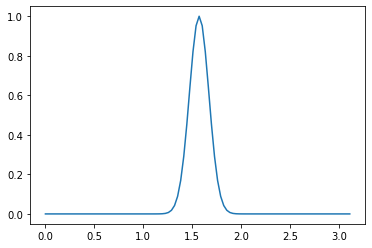

In [43]:
V_plot=np.array( [V(x[i])for i in range(N)]) 
plt.plot(x,V_plot)  #Draw the potential function

In [44]:
K=np.array([1,2,3,4,5,6,7,8,9,10,11])
L=K.shape[0]
PINN_error=np.zeros(K.shape)
Total_error=np.zeros(K.shape)
L2_norm=np.zeros(K.shape)
theta=np.empty((L,))

In [45]:
def DO(k):
    w0=np.random.multivariate_normal(np.zeros(k*N) , np.identity(k*N))
    A=fmin_l_bfgs_b(objective, w0, approx_grad=1, disp=10)
    A=fmin_l_bfgs_b(PINN_Error, w0, approx_grad=1, disp=10)
    A=fmin_l_bfgs_b(objective, w0, approx_grad=1, disp=10)
    #A=fmin_l_bfgs_b(PINN_Error, w0, approx_grad=1, disp=10)
    #A=fmin_l_bfgs_b(objective, w0, approx_grad=1, disp=10)
    theta=A[0]  #Get the parameter
    E1=A[1]
    E2=PINN_Error(theta)
    E3=L2(theta)
    print('Total error : '+str(E1))
    print('PINN error : '+str(E2))
    print('L2 norm : '+str(E3))
    c,w,b=t_to_p(theta)
    plot= np.array( [net(c,w,b,x[i]) for i in range(N)] ) #Get the solution
    plt.plot(x,plot)
    plt.plot(x,np.abs(plot))  #Draw the solution
    plt.show()
    return E1,E2,E3

Total error : 35.93081293426019
PINN error : 633.9987633524703
L2 norm : 2.076431985022223


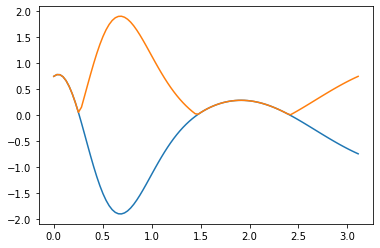

In [46]:
A=DO(3) #5

Total error : 1.481833604709961
PINN error : 1.481833604709961
L2 norm : 0.1285069677348072


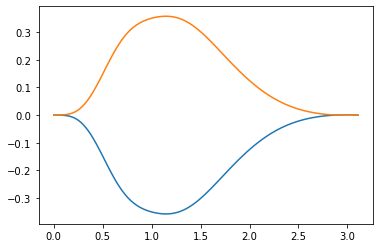

In [18]:
A=DO(1) #4

Total error : 1.7803530940804926
PINN error : 9.874102503825867
L2 norm : 0.9893864442573049


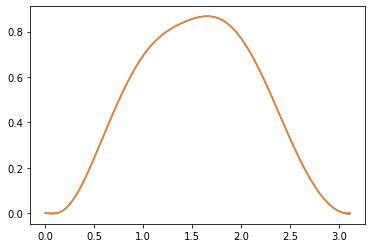

In [16]:
A=DO(1) # 3

Total error : 1.8617161303708027
PINN error : 47.36763248706929
L2 norm : 0.9897093594511703


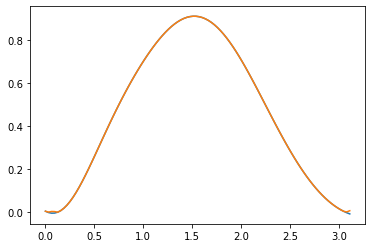

Total error : 1.987168154045218
PINN error : 162.59395894243949
L2 norm : 0.9897078505370885


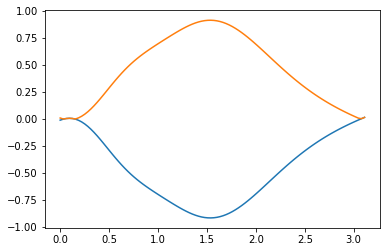

Total error : 2.428566361349304
PINN error : 336.56436412839
L2 norm : 0.988153386237362


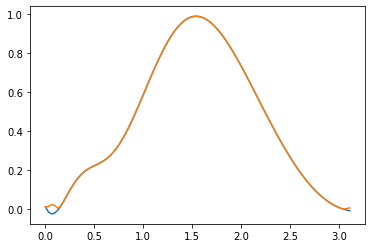

Total error : 2.112301086931203
PINN error : 128.07189338253184
L2 norm : 0.9884068430817234


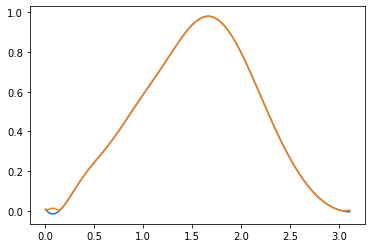

Total error : 12.84414816721868
PINN error : 2442.8739029797257
L2 norm : 0.9732378281714067


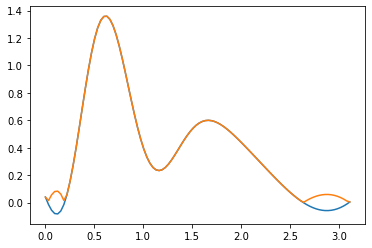

Total error : 4.331228777960442
PINN error : 145.3441423598597
L2 norm : 1.048269834507384


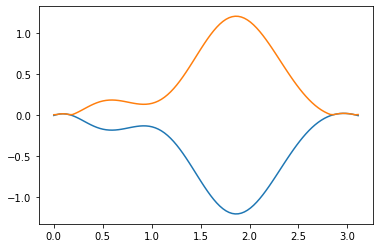

Total error : 4.398224129907758
PINN error : 2031.2607391686104
L2 norm : 1.0144342819505032


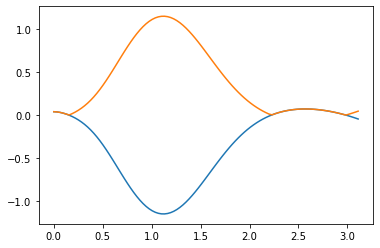

Total error : 5.403027740815515
PINN error : 1145.0639739780108
L2 norm : 0.9899932093555925


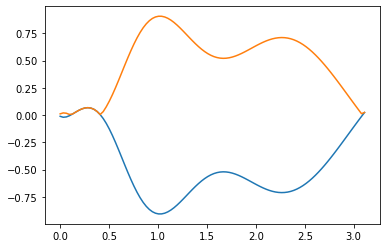

Total error : 48.36887291826345
PINN error : 19257.76610119965
L2 norm : 0.7941616956351137


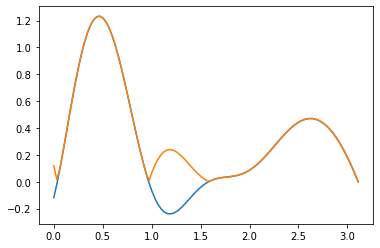

Total error : 65.17359067985623
PINN error : 68403.45698953127
L2 norm : 0.8968648808851523


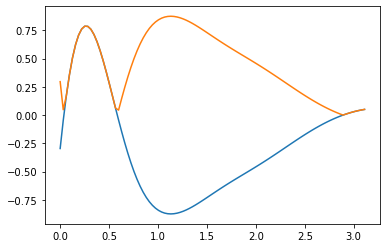

Total error : 8.598407040510551
PINN error : 214.20798821963325
L2 norm : 0.9742033233771265


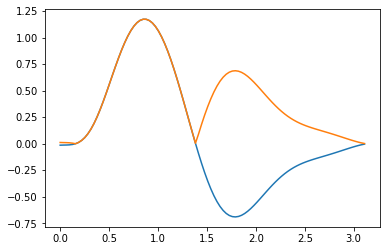

In [8]:
for j in range(K.shape[0]):
    A=DO(K[j])
    PINN_error[j]=A[1]
    Total_error[j]=A[0]
    L2_norm[j]=A[2]

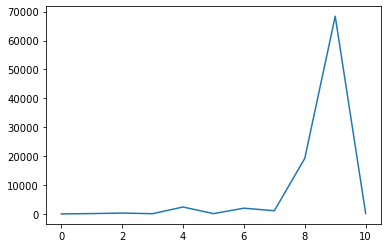

In [12]:
plt.plot(PINN_error)

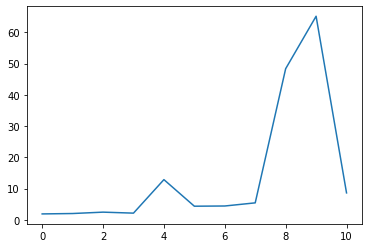

In [13]:
plt.plot(Total_error)

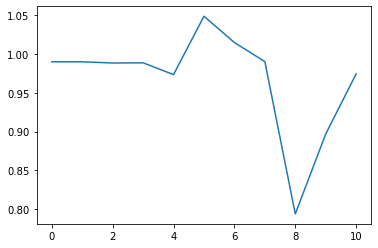

In [14]:
plt.plot(L2_norm)